<a href="https://colab.research.google.com/github/KhaSab5292/DS-Unit-2-Kaggle-Challenge/blob/master/Copy_of_assignment_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install matplotlib==3.1.0

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [6]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [7]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # replace very small values with zeros.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # drop duplicate columns
    X = X.drop(columns = ['quantity_group', 'water_quality', 'extraction_type', 
                          'extraction_type_group', 'payment', 'source', 'waterpoint_type'])
    X['quality_group'] = X['quality_group'].str.replace('good', 'soft')
    X['payment_type'] = X['payment_type'].str.replace('on failure', 'upon failure')
    
    # Drop recorded_by (never varies) and id (always varies, random)
    X = X.drop(columns = ['recorded_by', 'id'])
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format = True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns = 'date_recorded')
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
test = wrangle(test)

train.shape, test.shape

((59400, 34), (14358, 33))

In [8]:
from sklearn.model_selection import train_test_split

# Split train into train & val. Make val the same size as test.

train, val = train_test_split(train,  test_size = len(test),  
                              stratify = train['status_group'], random_state = 42)

train.shape, val.shape, test.shape

((45042, 34), (14358, 34), (14358, 33))

In [10]:
target = 'status_group'

# Arrange data into X features matrix and y target vector
# so we use the high-cardinality categoricals features
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, 

((45042, 33), (45042,), (14358, 33), (14358,), (14358, 33))

In [25]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy = 'mean'), 
    RandomForestClassifier(n_estimators = 400, min_samples_leaf = 3, 
                           random_state = 42, n_jobs = -1)
)

# Fit the model
pipeline.fit(X_train, y_train)

# Score on train and val
print('Training accuracy:', pipeline.score(X_train, y_train))
print('Validation accuracy:', pipeline.score(X_val, y_val))


Training accuracy: 0.9112161982149993
Validation accuracy: 0.8091656219529182


# **Plot a confusion matrix for your Tanzania Waterpumps model.**

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

y_pred = pipeline.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[7121,  115,  562],
       [ 602,  289,  152],
       [1226,   48, 4243]])

In [23]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns = columns, index = index)
    return table

plot_confusion_matrix(y_val, y_pred)

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,7121,115,562
Actual functional needs repair,602,289,152
Actual non functional,1226,48,4243


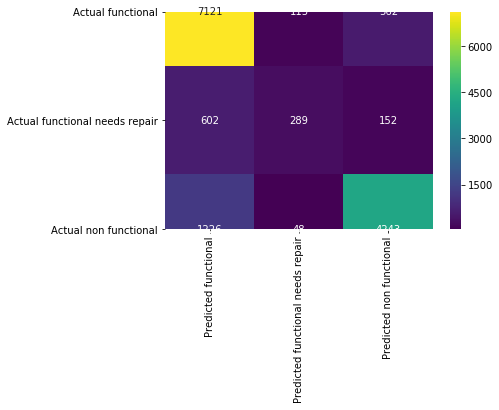

In [32]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns = columns, index = index)
    return sns.heatmap(table, annot = True, fmt = 'd',
                       cmap = 'viridis')

plot_confusion_matrix(y_val, y_pred);

# **Submit your final predictions to our Kaggle competition.**

In [0]:
# Predict on test
y_pred = pipeline.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('My_submission.csv', index = False)

In [0]:
from google.colab import files

# download submission
files.download('My_submission.csv')